In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
data = np.loadtxt('../data/waypoints.txt')

In [4]:
def create_pose(xp, yp, theta):
    
    ct = np.cos(theta)
    st = np.sin(theta)
    
    pose = np.array([[ct, -st, xp], [st, ct, yp], [0, 0, 1]])
    
    return pose


def invert_pose(pose):
    return np.linalg.inv(pose)


def invert_pose_analytical(pose):
    
    ct = pose[0, 0]
    st = pose[1, 0]
    
    xp = pose[0, 2]
    yp = pose[1, 2]
    
    pose_inv = np.array([[ct, st, -(xp*ct + yp*st)], [-st, ct, xp*st - yp*ct], [0, 0, 1]])
    
    return pose_inv


def transform_points(points, pose):
    
    res = []
    
    for i in range(len(points)):
        
        pt = points[i, :]
        pt_h = np.array([pt[0], pt[1], 1])
        pt_t = np.dot(pose, pt_h)
        
        transformed = np.array([pt_t[0] / pt_t[2], pt_t[1] / pt_t[2]])
        
        res.append(transformed)
        
    return np.array(res)
    
    
def dist(x1, x2):
    return np.linalg.norm(x1 - x2)


def find_closest_index(points_c):
    
    origin = np.array([0, 0])
    distances = np.array([dist(p, origin) for p in points_c])
    
    closest_idx = distances.argmin()
    
    return closest_idx, distances[closest_idx]


def get_next_points(points_c, start_idx, n_points):
    
    n = len(points_c)
    
    xs = []
    ys = []
    count = 0
    idx = start_idx
    
    while count < n_points:
        
        x = points_c[idx, 0]
        y = points_c[idx, 1]
        
        xs.append(x)
        ys.append(y)
        
        count += 1
        idx += 1
        if idx == n:
            idx = 0
            
    return np.array(xs), np.array(ys)


def polyfit_n(points_c, start_idx, dim, n_points):
        
    xs, ys = get_next_points(points_c, start_idx, n_points)
    return np.polyfit(xs, ys, dim)  
        

def plot_poly(coefs, x0, x1):
    
    poly = np.poly1d(coefs)
    
    x = np.linspace(x0, x1)
    y = poly(x)

    plt.plot(x, y)
    
    
def estimate_line(p1, p2):
    
    x1, y1 = p1
    x2, y2 = p2
        
    slope = (y2 - y1) / (x2 - x1)
    intercept = y2 - slope * x2
    
    return slope, intercept
    

def closest_line(points_c, closest_idx, closest_dist):
    
    if closest_dist > 0:
        
        p1 = points_c[closest_idx - 1, :]
        p2 = points_c[closest_idx, :]
        
    else:
        
        p1 = points_c[closest_idx, :]
        p2 = points_c[closest_idx + 1, :]
        
    slope, intercept = estimate_line(p1, p2)
    
    return slope, intercept, p1, p2


def measure_errors(slope, intercept):
    
    x0, y0 = 0, 0
    
    epsi = math.atan(slope)
    cte = abs(intercept + slope * x0 - y0) / math.sqrt(1 + slope**2)
    
    return cte, epsi

In [5]:
car_x = -40.62
car_y = 108.73
car_psi = 3.733651

car_pose_in_map = create_pose(car_x, car_y, car_psi) 
t_map_to_car = invert_pose(car_pose_in_map)
points_c = transform_points(data, t_map_to_car)

ptsx = np.array([-32.16173,-43.49173,-61.09,-78.29172,-93.05002,-107.7717])
ptsy = np.array([113.361,105.941,92.88499,78.73102,65.34102,50.57938])

pts = np.array((ptsx, ptsy)).T
pts_c = transform_points(pts, t_map_to_car)

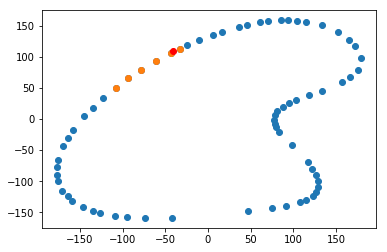

In [6]:
plt.plot(data[:, 0], data[:, 1], 'o')

plt.plot(ptsx, ptsy, 'o')
plt.plot(car_x, car_y, 'ro')

In [7]:
def plot_pts_poly(pts):
    
    ptsx = pts[:, 0]
    ptsy = pts[:, 1]

    coefs = np.polyfit(ptsx, ptsy, 3)
    plot_poly(coefs, ptsx.min(), ptsx.max())
    print('Polynomial coefficients:', coefs)

    plt.plot(ptsx, ptsy, 'o')
    

Polynomial coefficients: [ 3.31873438e-06 -1.97547218e-03  5.00596467e-01  1.31647621e+02]


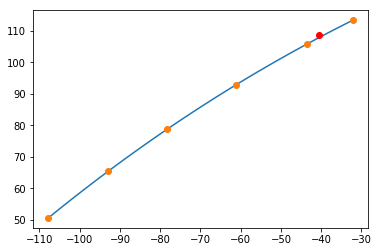

In [8]:
plot_pts_poly(pts)
_ = plt.plot(car_x, car_y, 'ro')

Polynomial coefficients: [-9.85152858e-07  1.35139032e-03  2.14533972e-03  7.44286899e-01]


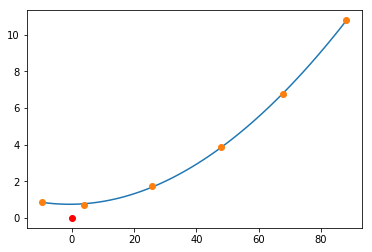

In [9]:
plot_pts_poly(pts_c)
_ = plt.plot(0, 0, 'ro')

Closest index: 1
Distance to the closest waypoint: 4.003168019568989
slope:		-0.012247857457099422
intercept:	0.7599170008006434


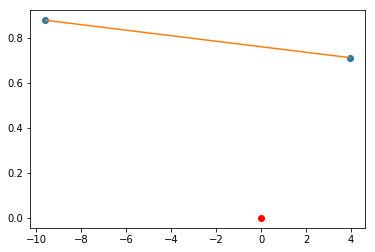

In [10]:
closest_idx, closest_dist = find_closest_index(pts_c)
print('Closest index:', closest_idx)
print('Distance to the closest waypoint:', closest_dist)

slope, intercept, p1, p2 = closest_line(pts_c, closest_idx, closest_dist)

plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'o')
plt.plot(0, 0, 'ro')

plot_poly([slope, intercept], p1[0], p2[0])

print('slope:\t\t{}\nintercept:\t{}'.format(slope, intercept))

In [11]:
cte, epsi = measure_errors(slope, intercept)
print('cte:\t{}\nepsi:\t{}'.format(cte, epsi))

cte:	0.7598600096331829
epsi:	-0.012247245078467013
